# Neural net for estimating pedestrian volume
We are going to apply object detection to Google Street View images to estimate pedestrian volume of the location.
Here we use Faster-RCNN, RestNet50, pre-trained on COCO.


In [1]:
import sys
sys.path.append("../src")
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import transform as T
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

torch.cuda.is_available()

True

# load a model 
pre-trained on COCO, resnet 50

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda')
model.to(device)
_ = model.eval()

In [11]:
# functions

def get_prediction(image_path, model, threshold=0.2):
    
    # convert image
    img = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    img, _ = transform(img, {})
    
    # forward
    pred = model([img.cuda()])
    
    # process result
    is_people = (pred[0]['labels'] == 1) & ((pred[0]['scores'] > threshold))
    box = [[i[0][0], i[0][1], i[0][2], i[0][3]] for i in list(pred[0]['boxes'][torch.nonzero(is_people)].detach().cpu() .numpy())]
    score = list(pred[0]['scores'][torch.nonzero(is_people)].flatten().detach().cpu().numpy())
    
    return box, score, img


def vis_detections(im, boxes, scores, saveas=None):
    """Draw detected bounding boxes."""
    im = Image.fromarray(im.mul(255).permute(1, 2, 0).byte().numpy())
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i, bbox in enumerate(boxes):
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1],
                          fill=False,
                          edgecolor='red',
                          linewidth=3.5))
        ax.text(
            bbox[0],
            bbox[1] - 2,
            '{:.3f}'.format(scores[i]),
            fontsize=14,
            color='white')
    plt.axis('off')
    plt.tight_layout()
    if saveas:
        plt.savefig(saveas)
        plt.close()
    else:
        plt.draw()

def run_detect(image_path, model, outdir="../data/annotation", threshold=0.2):
    box, score, img = get_prediction(image_path, model, threshold=threshold)
    image_name = image_path.split('/')[-1]
    result = {'image': image_name, 'score': score}
    if outdir:
        vis_detections(img, box, score, saveas=os.path.join(outdir, 'anno_' + image_name))
    else:
        vis_detections(img, box, score, saveas=None)
    return result

# Read image paths

In [5]:
image_dir = "../data/gsv"
images = [img_path for img_path in \
          glob.glob(image_dir+'/*.jpg')]

## Test with one image

{'image': 'image_23_80.jpg',
 'score': [0.9994392, 0.9992754, 0.9968231, 0.9913448, 0.9882839, 0.14967945]}

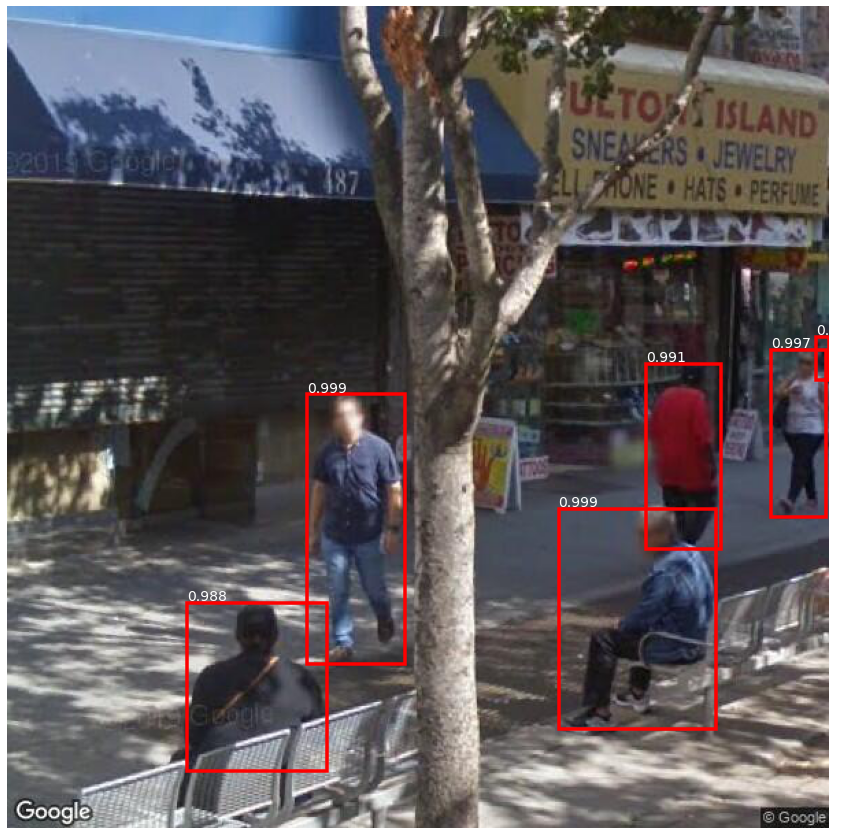

In [13]:
run_detect(images[0], model, outdir=None, threshold=0.1)

# Run all images

In [14]:
%%time
results = list(map(lambda x: run_detect(x, model, threshold=0.2), images))

CPU times: user 13min 30s, sys: 2min 11s, total: 15min 41s
Wall time: 6min 42s


In [26]:
df = pd.DataFrame.from_records(results)
df.columns = ['image', 'score']
df['lid'] = df['image'].str.split('_').str[1]
df = df.explode('score')
df.head()

,image,score,lid
0,image_23_80.jpg,0.999439,23
0,image_23_80.jpg,0.999275,23
0,image_23_80.jpg,0.996823,23
0,image_23_80.jpg,0.991345,23
0,image_23_80.jpg,0.988284,23


In [24]:
df.to_csv("../data/dataframe/nyc-cnn-exp.csv", index=False)